<a href="https://colab.research.google.com/github/pgeorgantopoulos/PINNs-Photogrammetry/blob/main/pinns/kalman_face_tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kalman minimal example for face tracking.

An MTCNN model locates a bbox of a single face and its center in each frame is a measurement. A prediction is made using a consant velocity Kalman model.

Inputs:

**prfx**: working directory

**filename**: name of webm/mp4 video

**scale**: (eg.320:180 16:9, 180:320 for 9:16. X:-1 preserves aspect ratio)

In [1]:
%pip install -q torch torchvision opencv-python-headless facenet-pytorch

ERROR: Operation cancelled by user
^C
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/pgeorgant/Documents/poselab/PINNs-Photogrammetry/.venv/lib/python3.12/site-packages/pip/__main__.py", line 24, in <module>
    sys.exit(_main())
             ^^^^^^^
  File "/home/pgeorgant/Documents/poselab/PINNs-Photogrammetry/.venv/lib/python3.12/site-packages/pip/_internal/cli/main.py", line 79, in main
    return command.main(cmd_args)
           ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pgeorgant/Documents/poselab/PINNs-Photogrammetry/.venv/lib/python3.12/site-packages/pip/_internal/cli/base_command.py", line 100, in main
    with self.main_context():
  File "/usr/lib/python3.12/contextlib.py", line 144, in __exit__
    next(self.gen)
  File "/home/pgeorgant/Documents/poselab/PINNs-Photogrammetry/.venv/lib/python3.12/site-packages/pip/_internal/cli/command_context.py", line 19, in main_context
  

In [ ]:
import os
from IPython.display import Video

# prfx = "/content/drive/MyDrive/Colab Notebooks/kalman_face_tracking"
prfx = ".kalman_face_tracking"
filename = "face4.webm"
fname = os.path.splitext(filename)[0]
large_vid_path = os.path.join(prfx,filename)
scale = "320:-1"
# scale = "180:-1"
small_vid_path = os.path.join(prfx,fname+"_small.mp4")
vid_path = os.path.join(prfx,fname+"_small_h264.mp4")
output_path = os.path.join(prfx,fname+"_mtcnn.mp4")
output_vid_path = os.path.join(prfx,fname+"_kalman.mp4")

# Scale down resolution and transcode to H.264
!ffmpeg -y -loglevel error -i "{large_vid_path}" -vf scale="{scale}" "{small_vid_path}"
!ffmpeg -y -loglevel error -i "{small_vid_path}" -c:v libx264 -preset veryfast -crf 23 -an -movflags +faststart "{vid_path}"

# Display the video
Video(vid_path, embed=True)

# Kalman for face tracking

In [2]:
import cv2
import torch
from facenet_pytorch import MTCNN
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

# Initialize MTCNN face detector
mtcnn = MTCNN(keep_all=True, device='cuda' if torch.cuda.is_available() else 'cpu')

# Re-open the video file to write the output
cap = cv2.VideoCapture(vid_path)
# cap = cv2.VideoCapture(0)  # Use webcam for real-time tracking

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create VideoWriter object
output_filename = output_path
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Or 'XVID'
out = cv2.VideoWriter(output_filename, fourcc, fps, (width, height))

frame_idx = 0

# Kalman initialization

## State model (assumed constant velocity)
dt = 1/fps # dt proportional to video frame rate
A = torch.tensor([  [1, 0, dt,0], # x1 = x1 + v1 * dt + 1/2 * a1 * dt^2
                    [0, 1, 0, dt], # x2 = x2 + v2 * dt + 1/2 * a2 * dt^2
                    [0, 0, 1, 0], # v1 = v1 + a1 * dt
                    [0, 0, 0, 1], # v2 = v2 + a2 * dt
                    ],dtype=torch.float32)

B = torch.tensor([  [0.5*dt**2, 0,         0,  0],
                    [0,         0.5*dt**2, 0,  0],
                    [0,         0,         dt, 0],
                    [0,         0,         0,  dt]
                    ],dtype=torch.float32)

u = torch.tensor([0, 9.81, 0, 9.81],dtype=torch.float32).view(-1,1) # acceleration vector (input)

## Measurement model
C = torch.tensor([  [1, 0, 0, 0],
                    [0, 1, 0, 0]
                    ],dtype=torch.float32)
    
## Initial conditions
s = torch.ones((A.shape[0],1))

## Parameters
S = torch.eye(s.shape[0]) * 100 # state covariance
# W = torch.eye(s.shape[0]) * 0.1 # state noise covariance
W = torch.tensor([  [dt**4/4, dt**3/2, 0,       0], # x1 = x1 + v1 * dt
                    [dt**3/2, dt**2,   0,       0], # v1 = v1
                    [0,       0,       dt**4/4, dt**3/2], # x2 = x1 + v2 * dt
                    [0,       0, dt**3/2,       dt**2], # v2 = v2
                    ],dtype=torch.float32)  # state noise covariance
V = torch.eye(2) * 0.001 # measurement noise covariance
########

# List to store Kalman predicted centers history
pred_history = []
center_gt_history = []

while True:

    ret, original_frame = cap.read()
    if not ret:
        break
    frame = original_frame.copy()
    # Convert BGR (OpenCV) to RGB (PIL)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # Convert frame to PIL Image
    frame_pil = transforms.ToPILImage()(frame_rgb)

    # Locate faces and get bounding boxes
    boxes, prb = mtcnn.detect(frame_pil)
    current_prb = prb.max()

    if boxes is not None:



        # Draw bbox certainty
        text = f"Prb: {current_prb:.2f}"
        text_size, _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        text_x = width - text_size[0] - 10
        text_y = text_size[1] + 10
        cv2.putText(frame, text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)

        # Kalman predict
        s = A @ s + B @ u
        S = A @ S @ A.T + W

        # If measurement present
        if current_prb>0.98:

            # Keep box with the highest certainty
            box = boxes[prb.argmax()]

            x1, y1, x2, y2 = box

            # Draw bounding box
            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)

            center_x = (x1 + x2) / 2
            center_y = (y1 + y2) / 2
            center_gt = torch.tensor([center_x, center_y], dtype=torch.float32).view(-1,1)
            # Draw current measurement
            cv2.circle(frame, (int(center_x), int(center_y)), 5, (255, 0, 0), -1)
            center_gt_history.append((int(center_x), int(center_y)))

            # Kalman update
            r = center_gt - C @ s
            R = C @ S @ C.T + V
            K = S @ C.T @ R.inverse()
            s = s + K @ r
            S = (torch.eye(s.shape[0]) - K @ C) @ S
    else:
        center_gt_history.append((np.nan,np.nan))

    x_pred = (C @ s)

    kalman_x, kalman_y = x_pred[0,0], x_pred[1,0]

    # Append the current Kalman predicted center to the history
    pred_history.append((int(kalman_x), int(kalman_y)))

    # Draw the entire history of Kalman centers
    for i,center in enumerate(pred_history):
            c = cv2.circle(frame, center, 1, (0, 0, 255), -1)
    # cv2.circle(frame, (int(kalman_x), int(kalman_y)), 3, (0, 0, 255), -1)


    # Write the frame to the output video
    out.write(frame)
    frame_idx += 1

    # if cv2.waitKey(1) & 0xFF == ord('q'):
    #     break

# Release everything when done
cap.release()
out.release()
# cv2.destroyAllWindows()

!ffmpeg -y -loglevel error -i "{output_path}" -c:v libx264 -preset veryfast -crf 23 -c:a aac -movflags +faststart "{output_vid_path}"
print(f"Output saved to {output_vid_path}")

Video(output_vid_path, embed=True)

ModuleNotFoundError: No module named 'cv2'

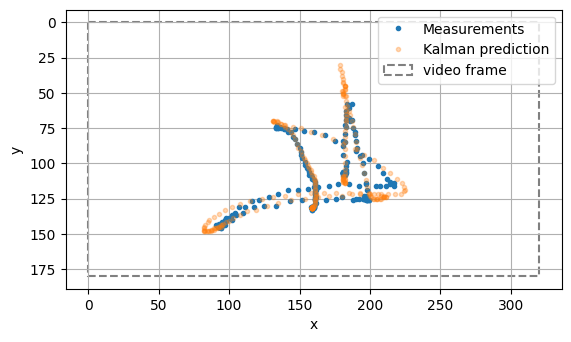

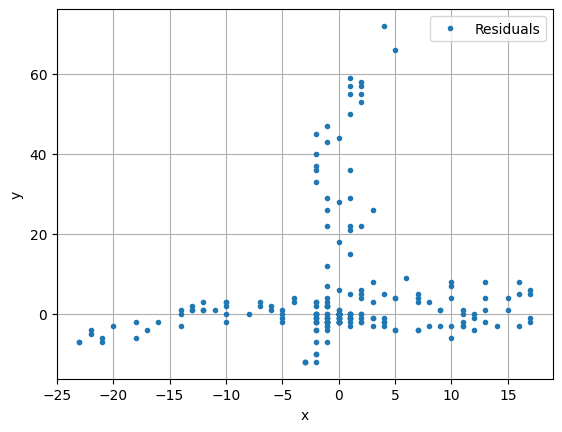

In [3]:
import matplotlib.patches as patches

frame_width = width
frame_height = height
plt.figure(1)
plt.plot([x for x,y in center_gt_history],[y for x,y in center_gt_history],'.',label="Measurements")
plt.plot([x for x,y in pred_history],[y for x,y in pred_history], '.', label='Kalman prediction',alpha=0.3)
rect = patches.Rectangle((0, 0), width, height, linewidth=1.5, edgecolor='gray', facecolor='none', linestyle='--',label="video frame")
plt.gca().add_patch(rect)
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('x')
plt.ylabel('y')
# plt.xlim(0, width)
# plt.ylim(height,0)
plt.grid()
plt.legend()

plt.figure(2)
plt.plot([x[0]-y[0] for x,y in zip(center_gt_history,pred_history)],[x[1]-y[1] for x,y in zip(center_gt_history,pred_history)],'.',label="Residuals")
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()

Video(output_vid_path, embed=True)